In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pickle
import cartopy.crs as ccrs
import geopandas as gpd
from palettable.colorbrewer.sequential import YlGnBu_9
import gdal

import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import osr

# Open common datasets

In [2]:
# ATL15
src_path = "ATL15_AA_0311_01km_001_01.nc"
ds = xr.open_dataset(src_path, group='delta_h')
indf = 5
ind0 = 1
dh = ds['delta_h'][indf,:,:] - ds['delta_h'][ind0,:,:]

# SMB Perturbation
M2_RF = xr.open_dataset("RF_Snow_Red_prelim.nc")['IS2_opt']
M2_RF = M2_RF / M2_RF
M2_RF = M2_RF.fillna(1)

# Grounded mask
grounded_mask = np.load("grounded-mask/grounded_mask.npy")
grounded_mask = xr.DataArray(data=np.flipud(grounded_mask), dims=["y", "x"], coords=[ds['y'],ds['x']])

# Trim to comain domain
dh = dh * grounded_mask * M2_RF

# Load in ensemble dFAC solutions

In [3]:
dFAC = np.load("Inference_Y_ensemble.npy")
dFAC_deterministic = np.load("Inference_Y.npy")
print(dFAC.shape)
print(dFAC_deterministic.shape)

(22977621, 100)
(22977621,)


In [4]:
# Calculate mean and standard deviation
dFAC_mean = np.mean(dFAC, axis=1)
dFAC_std = np.std(dFAC, axis=1)

# Plot map pf standard deviation dFAC

In [5]:
dFAC_std = xr.DataArray(data=np.reshape(dFAC_std, dh.shape), dims=["y", "x"], coords=[dh['y'], dh['x']])
dFAC_std = dFAC_std * grounded_mask * M2_RF

dFAC_deterministic = xr.DataArray(data=np.reshape(dFAC_deterministic, dh.shape), dims=["y", "x"], coords=[dh['y'], dh['x']])
dFAC_deterministic = dFAC_deterministic * grounded_mask * M2_RF


In [6]:
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
df = df.to_crs(epsg='3031')
n_poly = len(df['geometry'])

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


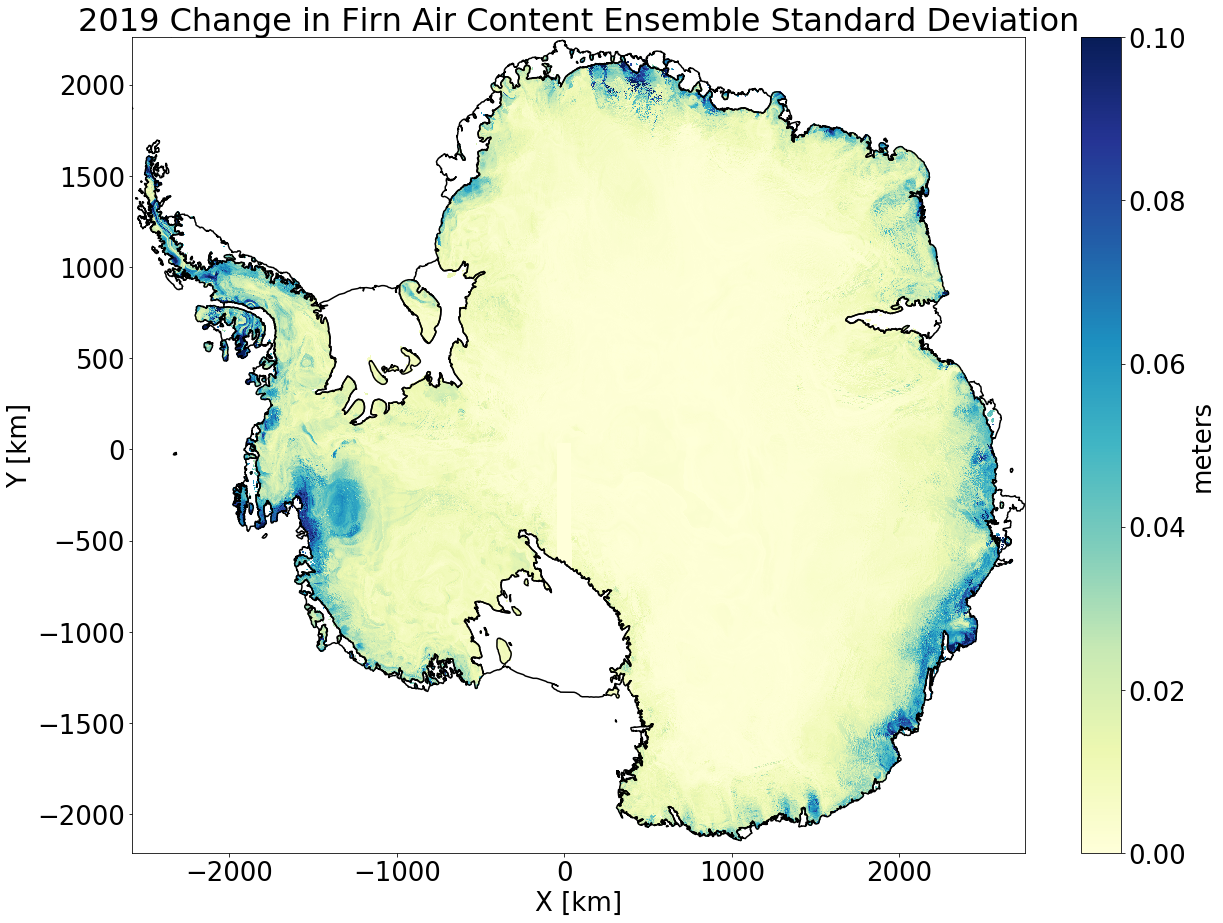

In [7]:
# dFAC
# lim = np.max(np.abs(dFAC_std))
lim = 0.1

plt.figure(figsize=(20, 15))

for j in range(0, n_poly):
    x_poly, y_poly = df['geometry'][j].exterior.coords.xy
    x_poly = np.array(x_poly)
    y_poly = np.array(y_poly)
    x_poly = np.append(x_poly/1000, x_poly[0]/1000)
    y_poly = np.append(y_poly/1000, y_poly[0]/1000)
    plt.plot(x_poly, y_poly, 'k-')

plt.pcolormesh(dFAC_std['x']/1000, dFAC_std['y']/1000, \
           dFAC_std, cmap=YlGnBu_9.mpl_colormap, \
          vmin=0, vmax=lim, rasterized=True)
cb = plt.colorbar()
cb.set_label("meters", fontsize=26)
cb.ax.tick_params(labelsize=26) 
plt.xlabel("X [km]", fontsize=26)
plt.ylabel("Y [km]", fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.title("2019 Change in Firn Air Content Ensemble Standard Deviation", fontsize=32)
plt.xlim([dFAC_std['x'].min()/1000-55, dFAC_std['x'].max()/1000+55])
plt.ylim([dFAC_std['y'].min()/1000-35, dFAC_std['y'].max()/1000+35])
plt.savefig("figures/dFAC_std_map_AIS.pdf", dpi=100)

# Plot ensemble histogram of ice sheet average dFAC

In [8]:
tmp = dFAC.flatten()
tmp = tmp.reshape((4401, 5221, 100))
tmp.shape
dFAC_ensemble = xr.DataArray(data=tmp, dims=["y", "x", "ensemble"], coords=[dh['y'], dh['x'], np.arange(1, 101)])
dFAC_ensemble = dFAC_ensemble * grounded_mask * M2_RF
ice_sheet_average_dFAC = dFAC_ensemble.mean(dim='x').mean(dim='y').values

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


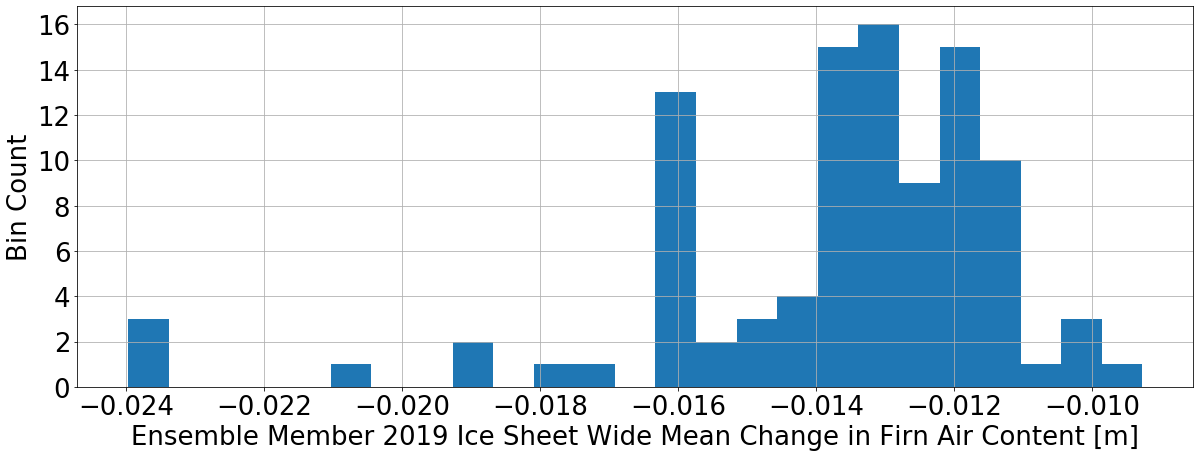

In [9]:
plt.figure(figsize=(20, 7))
plt.hist(ice_sheet_average_dFAC, bins=25)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.xlabel("Ensemble Member 2019 Ice Sheet Wide Mean Change in Firn Air Content [m]", fontsize=26)
plt.ylabel("Bin Count", fontsize=26)
plt.grid()
plt.savefig("figures/dFAC_AIS_ensemble.pdf", dpi=100)

# Create Figure 5
Box and whisker plots showing min, -std, mean, deterministic, +std, max basin average dFAC values

In [10]:
# %%bash
# ml intel/17.4; ml proj/6.0.0; ml gdal/3.4.2; ml netcdf;

# # This works for getting individual basins. But sets 1 outside, which is also a basin number!
# gdal_rasterize -b 1 -a ID GSFC_DrainageSystems.shp out.tif 

# # Get the inside of the polygons
# gdal_translate -b 1 NETCDF:ATL15_AA_0311_01km_001_01.nc:/delta_h/delta_h out2.tif
# gdal_rasterize -i -burn -9999 GSFC_DrainageSystems.shp out2.tif

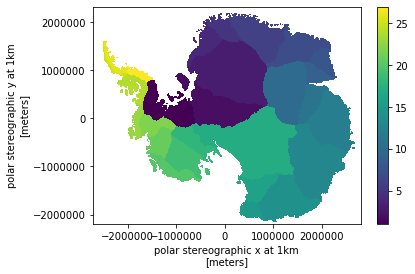

In [11]:
tif2 = gdal.Open("/projects/erke2265/tmp/out2.tif")
band2 = tif2.GetRasterBand(1)
basins2 = band2.ReadAsArray()
basins2[basins2<-100] = np.nan
basins2[basins2>=-10] = 1
basins2 = xr.DataArray(data=np.flipud(basins2), dims=["y", "x"], coords=[ds['y'],ds['x']])

tif = gdal.Open("/projects/erke2265/tmp/out.tif")
band = tif.GetRasterBand(1)
basins = band.ReadAsArray()
basins = xr.DataArray(data=np.flipud(basins), dims=["y", "x"], coords=[ds['y'],ds['x']])
basins = basins * grounded_mask * basins2
basins.plot()

In [23]:
# n_basins = 28 # Full ice sheet, 27 basins. 28 total
# n_values = 6
# data = np.zeros([n_basins, n_values]); data[:] = np.nan

# for j in range(0, n_basins):
# # for j in range(0, 2):
#     print("Basin " + str(j))
    
#     # Entire ice sheet
#     if j == 0: 
#         basin_mean = dFAC_ensemble.mean(dim='x').mean(dim='y').values
#         data[j, 0] = np.min(basin_mean) # minima
#         data[j, 1] = np.mean(basin_mean) - np.std(basin_mean) # neg_std
#         data[j, 2] = np.mean(basin_mean) # mean
#         data[j, 3] = dFAC_deterministic.mean(dim='x').mean(dim='y').values # deterministic
#         data[j, 4] = np.mean(basin_mean) + np.std(basin_mean) # std
#         data[j, 5] = np.max(basin_mean) # maxima
        
#     # Individual basin
#     else:
#         basin_mask = basins.where(basins == j) / basins.where(basins == j)
#         basin_values = dFAC_ensemble * basin_mask
#         basin_mean = dFAC_ensemble.mean(dim='x').mean(dim='y').values
#         data[j, 0] = np.min(basin_mean) # minima
#         data[j, 1] = np.mean(basin_mean) - np.std(basin_mean) # neg_std
#         data[j, 2] = np.mean(basin_mean) # mean
#         data[j, 3] = (dFAC_deterministic * basin_mask).mean(dim='x').mean(dim='y').values # deterministic
#         data[j, 4] = np.mean(basin_mean) + np.std(basin_mean) # std
#         data[j, 5] = np.max(basin_mean) # maxima

In [72]:
n_basins = 28 # Full ice sheet, 27 basins. 28 total
n_values = 100
data = np.zeros([n_values, n_basins]); data[:] = np.nan

for j in range(0, n_basins):
# for j in range(0, 2):
    
    # Entire ice sheet
    if j == 0: 
        print("AIS")
        basin_mean = dFAC_ensemble.mean(dim='x').mean(dim='y').values
        data[:, j] = basin_mean
        
        
    # Individual basin
    else:
        print("Basin " + str(j))
        basin_mask = basins.where(basins == j) / basins.where(basins == j)
        basin_values = dFAC_ensemble * basin_mask
        basin_mean = basin_values.mean(dim='x').mean(dim='y').values
        data[:, j] = basin_mean


AIS
Basin 1


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 2


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 3


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 4


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 5


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 6


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 7


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 8


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 9


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 10


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 11


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 12


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 13


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 14


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 15


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 16


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 17


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 18


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 19


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 20


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 21


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 22


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 23


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 24


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 25


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 26


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Basin 27


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Make violin plot

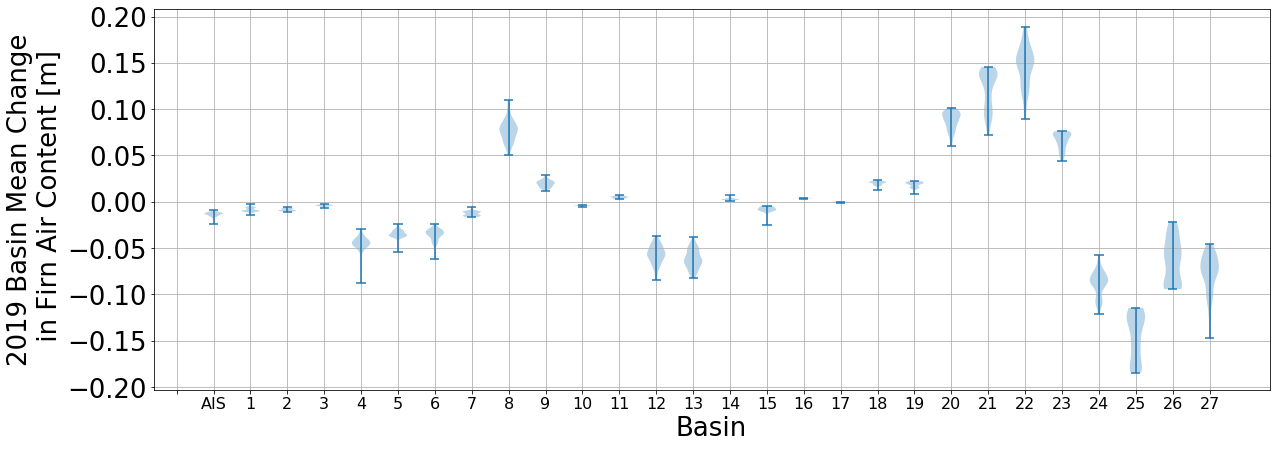

In [109]:
plt.figure(figsize=(20, 7))
plt.violinplot(data)
plt.grid()
plt.xticks(np.arange(n_basins+1), ['', 'AIS', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27'])  # Set text labels.
plt.xticks(fontsize=16)
plt.yticks(fontsize=26)
plt.xlabel("Basin", fontsize=26)
plt.ylabel("2019 Basin Mean Change\n in Firn Air Content [m]", fontsize=26)
plt.savefig("figures/ensemble_violin.pdf", dpi=100)

In [91]:
n_basins

28

In [94]:
data.shape

(100, 28)